In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/final_grape_data.zip

Archive:  /content/drive/MyDrive/final_grape_data.zip
   creating: final_grape_data/image/
  inflating: final_grape_data/image/1 (1).png  
  inflating: final_grape_data/image/1 (10).png  
  inflating: final_grape_data/image/1 (100).png  
  inflating: final_grape_data/image/1 (101).png  
  inflating: final_grape_data/image/1 (102).png  
  inflating: final_grape_data/image/1 (103).png  
  inflating: final_grape_data/image/1 (104).png  
  inflating: final_grape_data/image/1 (105).png  
  inflating: final_grape_data/image/1 (106).png  
  inflating: final_grape_data/image/1 (107).png  
  inflating: final_grape_data/image/1 (108).png  
  inflating: final_grape_data/image/1 (109).png  
  inflating: final_grape_data/image/1 (11).png  
  inflating: final_grape_data/image/1 (110).png  
  inflating: final_grape_data/image/1 (111).png  
  inflating: final_grape_data/image/1 (112).png  
  inflating: final_grape_data/image/1 (113).png  
  inflating: final_grape_data/image/1 (114).png  
  inflating: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, UpSampling2D,BatchNormalization, ZeroPadding2D, Reshape, Permute
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras
import os
import cv2

In [55]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.square(y_true)) + K.sum(K.square(y_pred))
    jac = (intersection) / (sum_ - intersection)

    return jac

In [56]:
from keras.applications.vgg16 import VGG16

def segnet(input_size=(512, 512, 1)):

    encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_size)

    # Encoding layer
    inp = Input(input_size)
    x = encoder.get_layer(name='block1_conv1')(inp)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = encoder.get_layer(name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = encoder.get_layer(name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = encoder.get_layer(name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = encoder.get_layer(name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Decoding Layer
    x = UpSampling2D()(x)
    x = Conv2D(512, (3, 3), padding='same', name='deconv1')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', name='deconv2')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', name='deconv3')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(512, (3, 3), padding='same', name='deconv4')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', name='deconv5')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', name='deconv6')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(256, (3, 3), padding='same', name='deconv7')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', name='deconv8')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', name='deconv9')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(128, (3, 3), padding='same', name='deconv10')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', name='deconv11')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(64, (3, 3), padding='same', name='deconv12')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (3, 3), padding='same', name='deconv13')(x)
    x = Activation('sigmoid')(x)

    pred = Reshape((input_size[0],input_size[1]))(x)

    return Model(inputs=inp, outputs=pred)

In [57]:
def read_and_preprocess_images(folder_path, target_size=(128, 128), grayscale=False):
    images = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            if grayscale:
                image = cv2.imread(image_path, 0)
                image = np.expand_dims(image, axis=-1)
            else:
                image = cv2.imread(image_path)
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, target_size)
            images.append(image)
    return np.array(images)

In [58]:
images = read_and_preprocess_images('/content/final_grape_data/image', target_size=(256, 256))
masks = read_and_preprocess_images('/content/final_grape_data/mask', target_size=(256, 256), grayscale=True)

In [59]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_train = np.array(images_train)
masks_train = np.array(masks_train)
images_test = np.array(images_test)
masks_test = np.array(masks_test)

In [60]:
model = segnet(input_size=(256,256,3))
model.compile(optimizer=Adam(lr=0.001), loss=dice_coef_loss, \
                      metrics=[iou, dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_125 (B  (None, 256, 256, 64)      256       
 atchNormalization)                                              
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_126 (B  (None, 256, 256, 64)      256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 128, 128, 64)      0   

In [61]:
history = model.fit(images_train, masks_train,
                    batch_size = 16,
                    epochs=45,
                    validation_data = (images_test, masks_test))

Epoch 1/45
42/42 [==============================] - 77s 654ms/step - loss: -0.7524 - iou: 0.6624 - dice_coef: 0.7547 - binary_accuracy: 0.8942 - val_loss: -0.2163 - val_iou: 0.1236 - val_dice_coef: 0.2193 - val_binary_accuracy: 0.1092
Epoch 2/45
42/42 [==============================] - 27s 644ms/step - loss: -0.8737 - iou: 0.7851 - dice_coef: 0.8729 - binary_accuracy: 0.9481 - val_loss: -0.2543 - val_iou: 0.1511 - val_dice_coef: 0.2576 - val_binary_accuracy: 0.2784
Epoch 3/45
42/42 [==============================] - 27s 645ms/step - loss: -0.8888 - iou: 0.8096 - dice_coef: 0.8893 - binary_accuracy: 0.9514 - val_loss: -0.3727 - val_iou: 0.2381 - val_dice_coef: 0.3754 - val_binary_accuracy: 0.5843
Epoch 4/45
42/42 [==============================] - 27s 655ms/step - loss: -0.9031 - iou: 0.8323 - dice_coef: 0.9032 - binary_accuracy: 0.9551 - val_loss: -0.6563 - val_iou: 0.4967 - val_dice_coef: 0.6594 - val_binary_accuracy: 0.8614
Epoch 5/45
42/42 [==============================] - 27s 641m

In [62]:
results = model.predict(images_test)
pred_mask = np.where(results > 0.5, 1, 0)

6/6 [==============================] - 2s 343ms/step


In [63]:
results[0].shape

(256, 256)

In [64]:
loss, iou, dice_coef, acc = model.evaluate(images_test, masks_test)
loss, iou, dice_coef, acc

6/6 [==============================] - 2s 294ms/step - loss: -0.9606 - iou: 0.9339 - dice_coef: 0.9613 - binary_accuracy: 0.9725


(-0.9606180787086487,
 0.9339377880096436,
 0.9613052010536194,
 0.9725258350372314)

In [66]:
model.save('vggsegnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


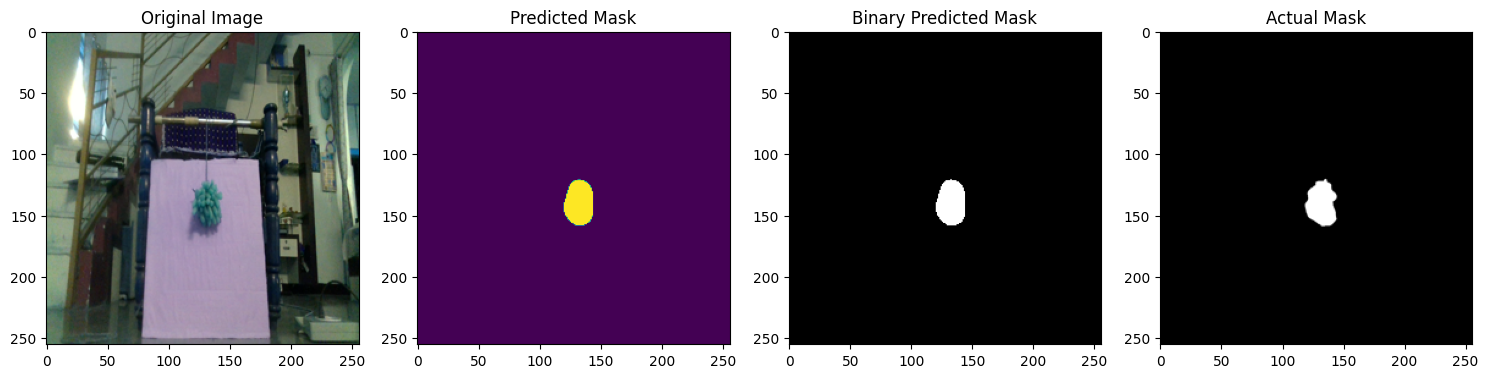

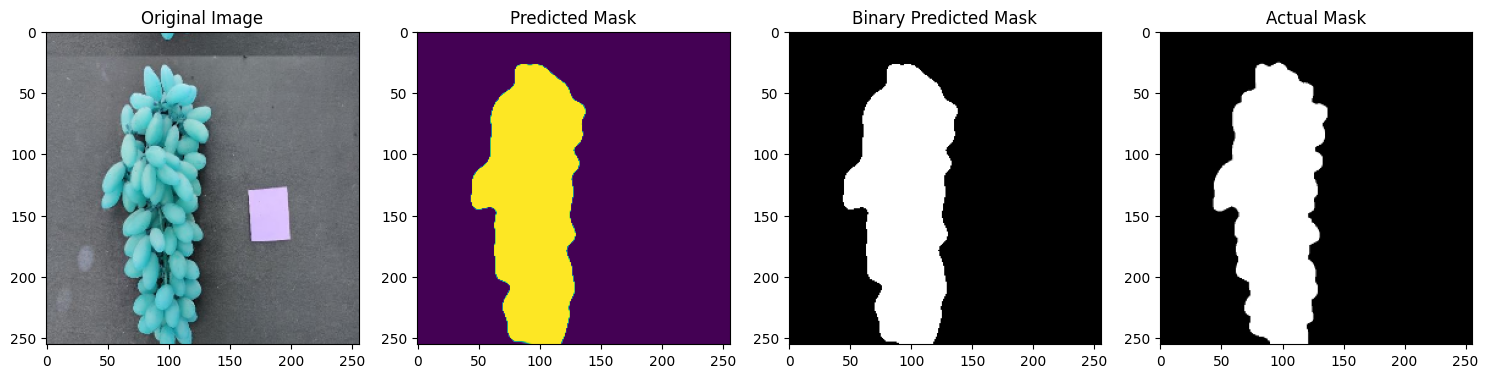

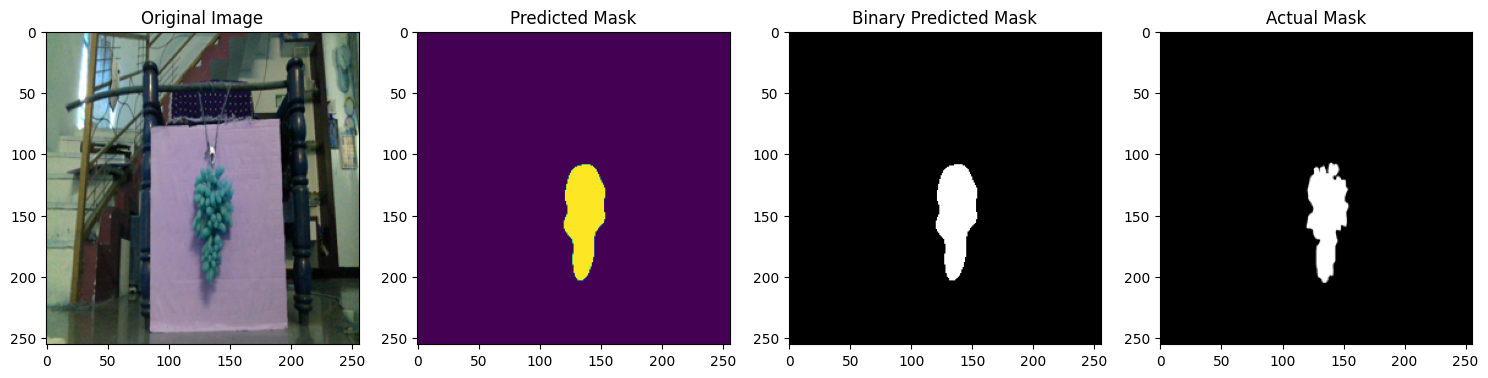

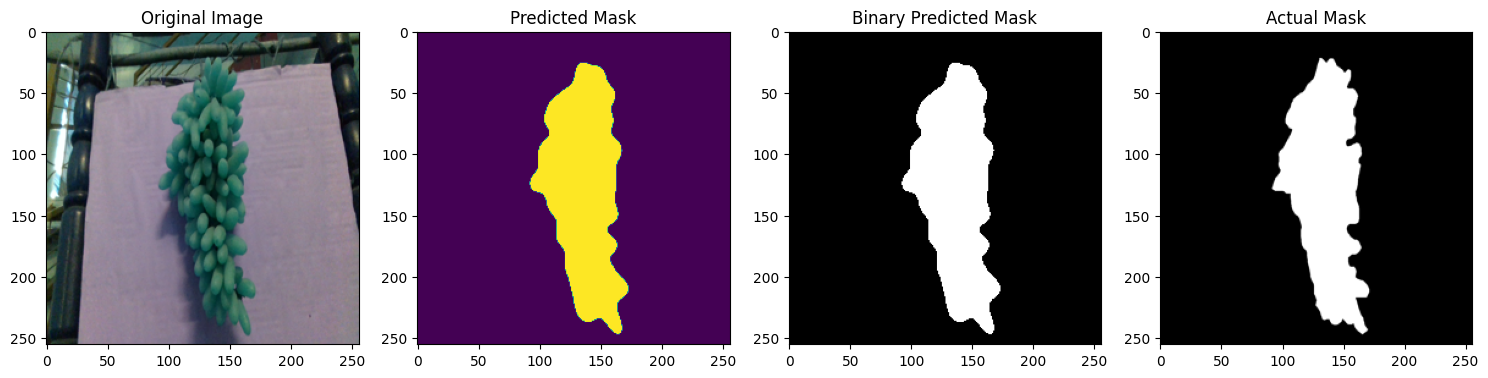

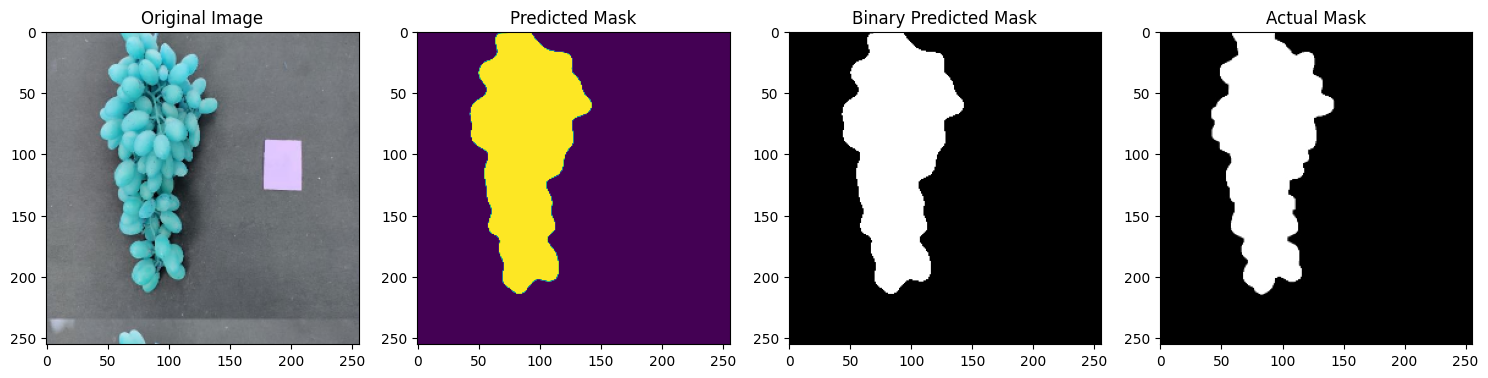

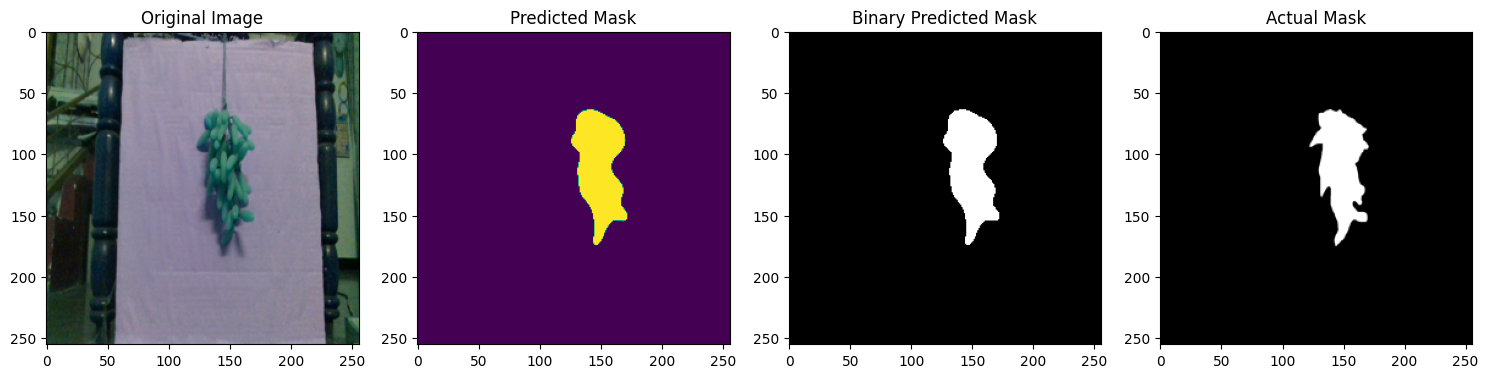

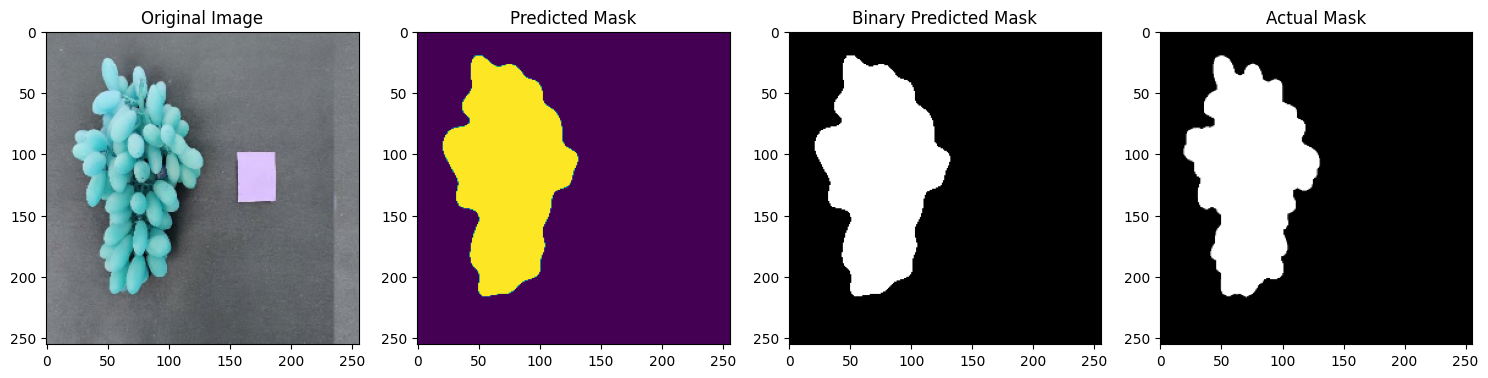

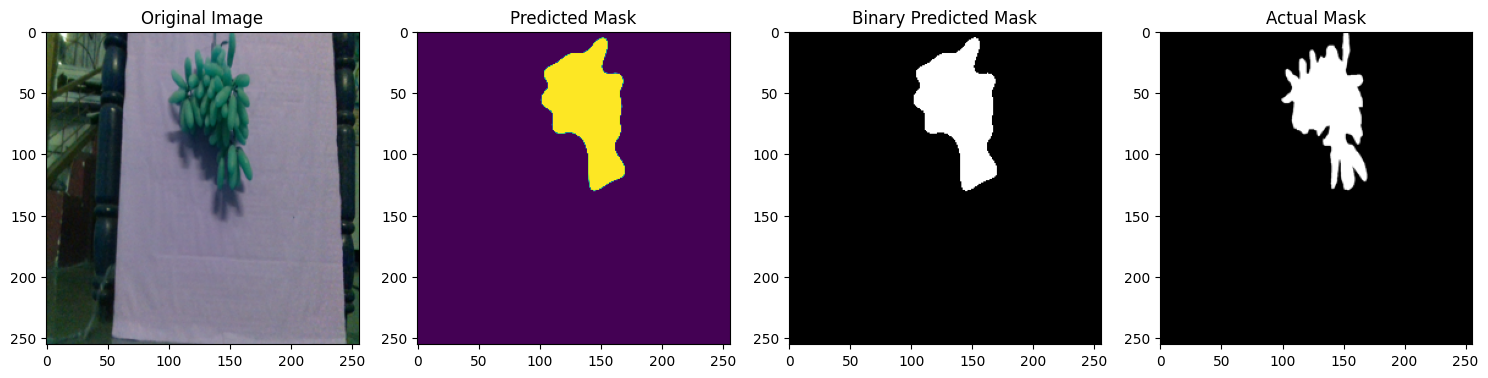

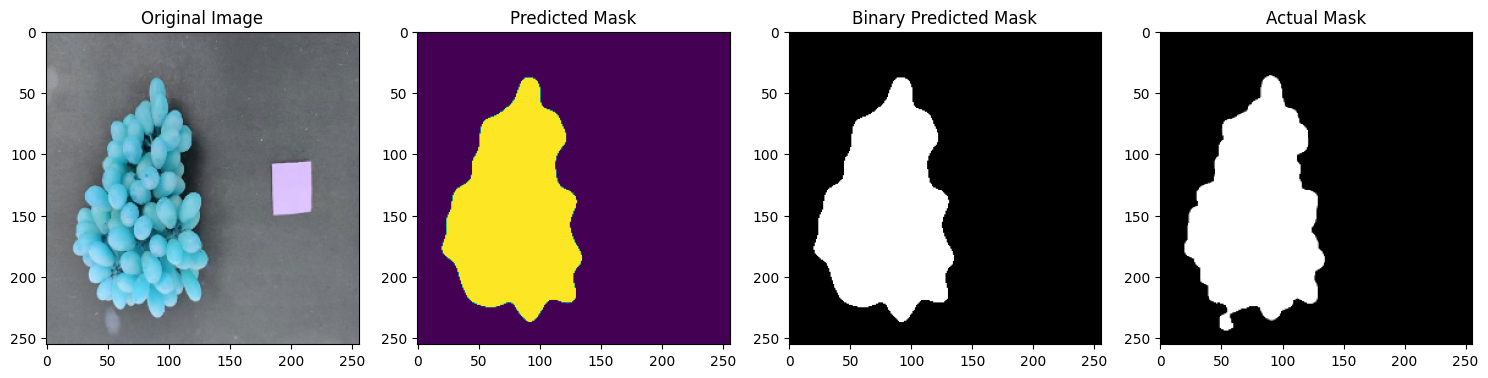

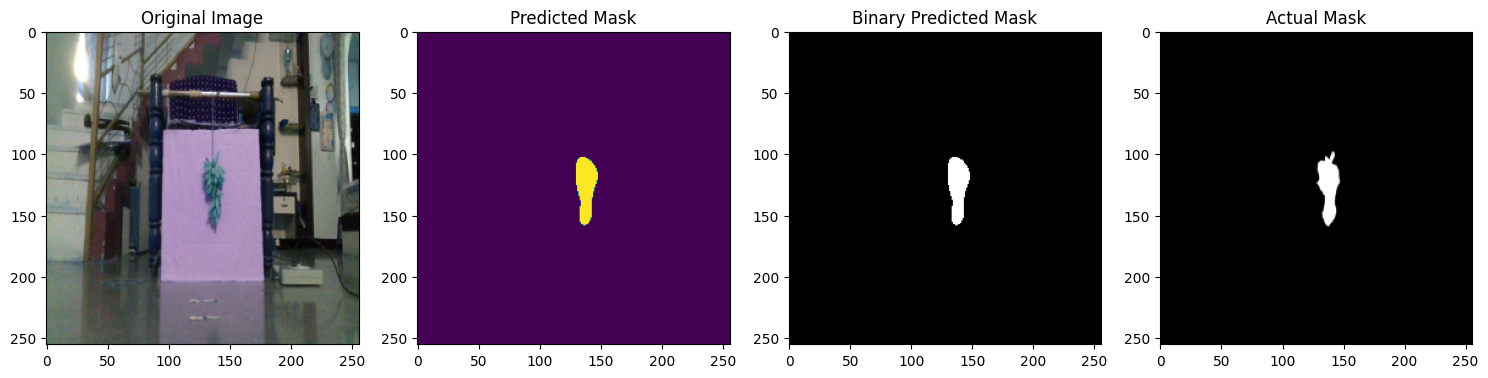

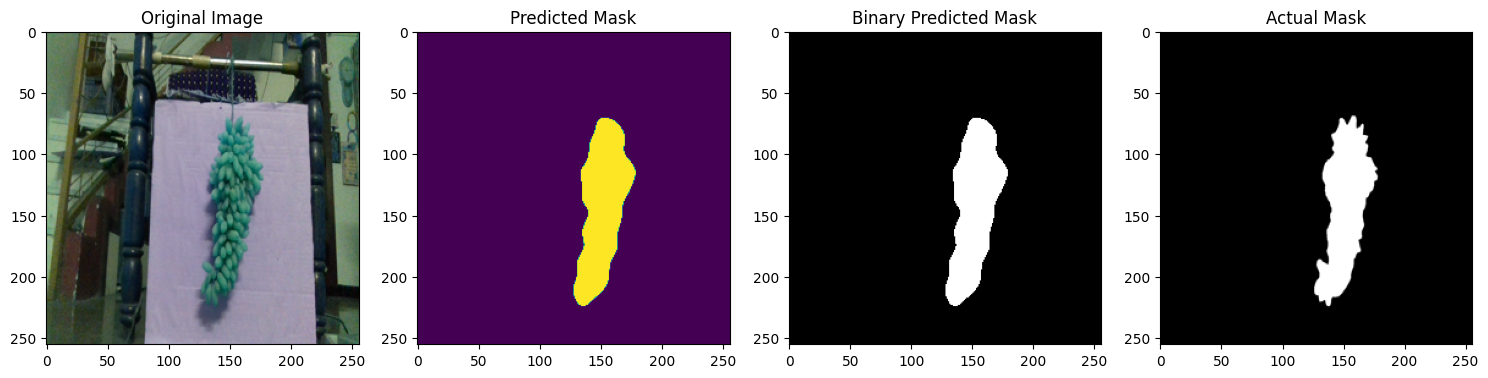

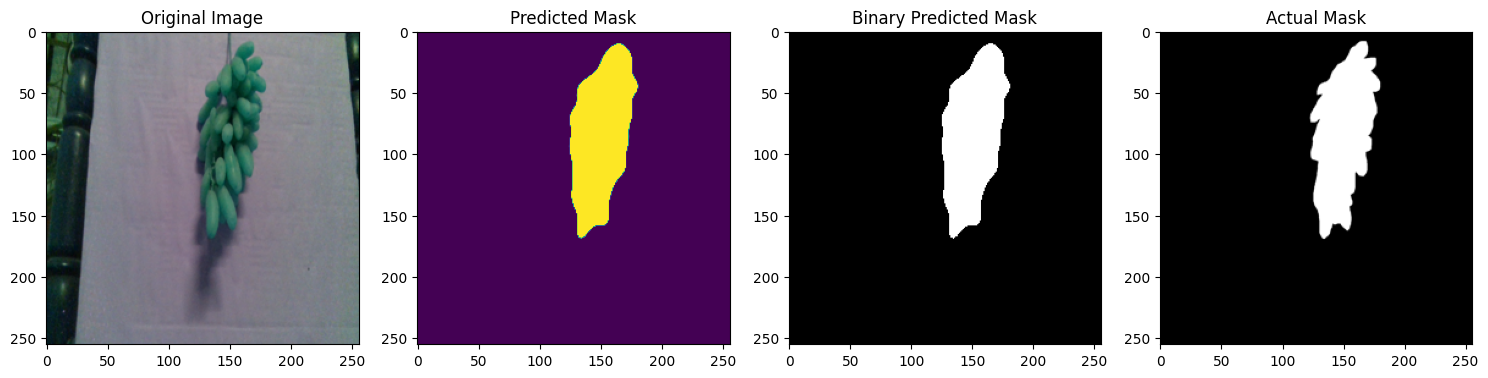

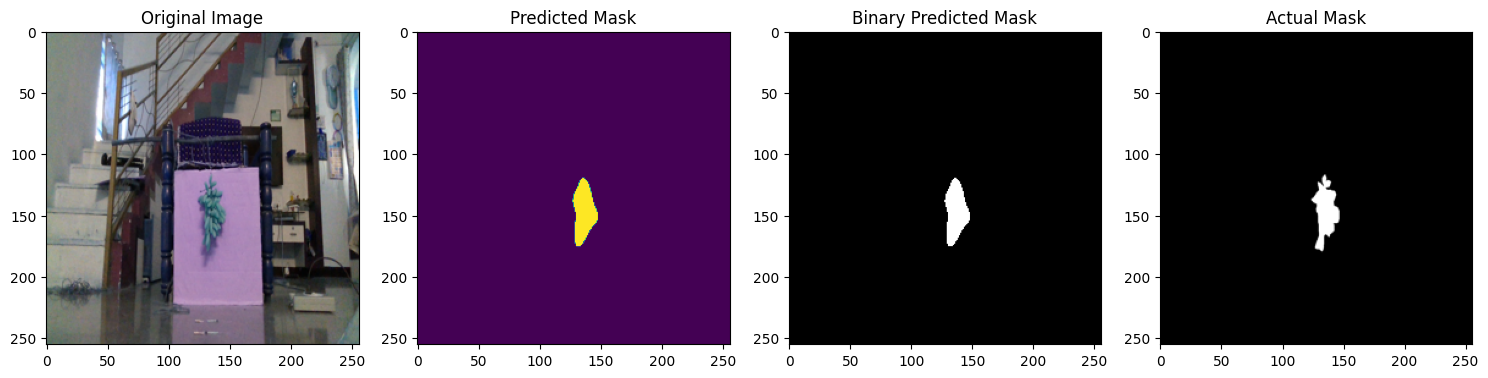

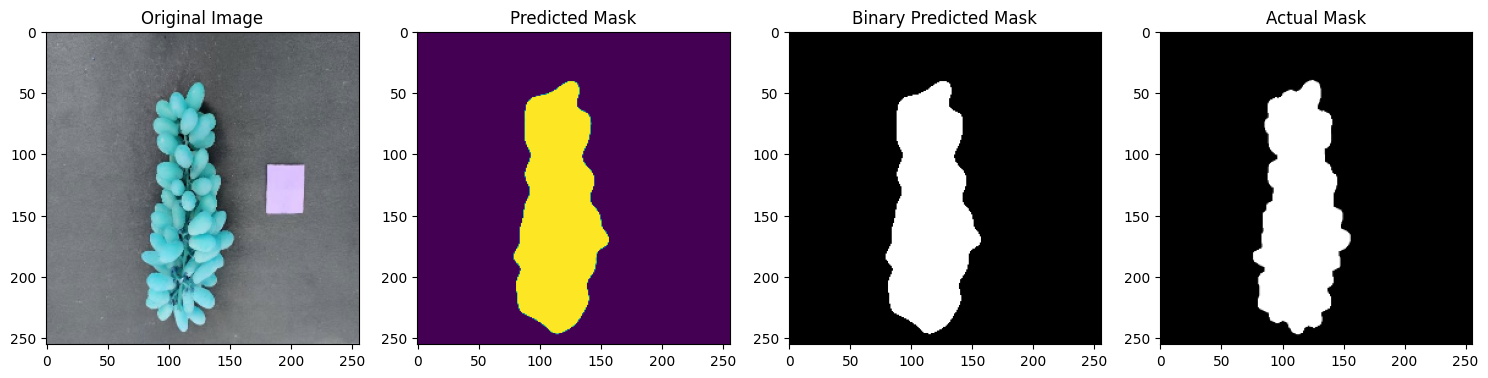

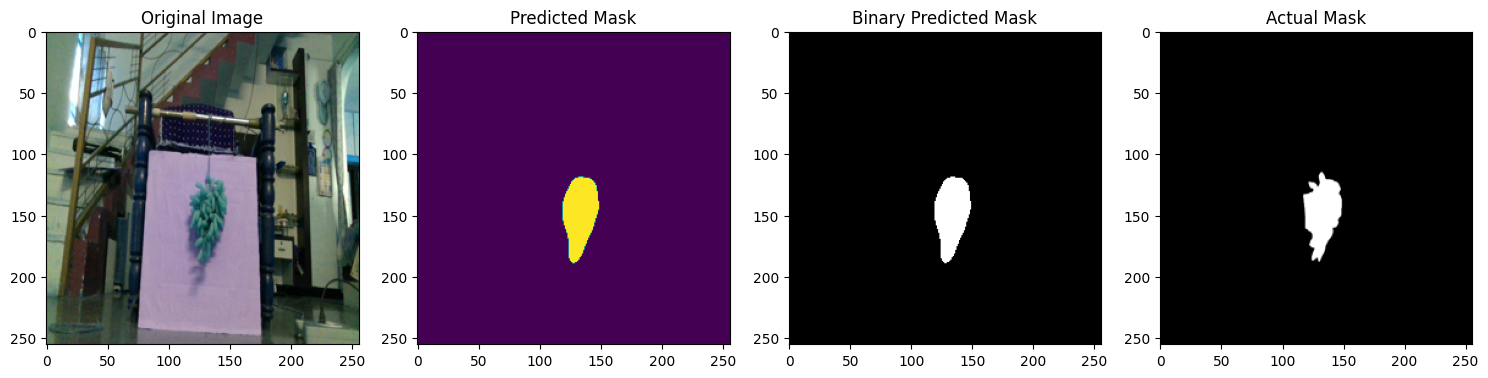

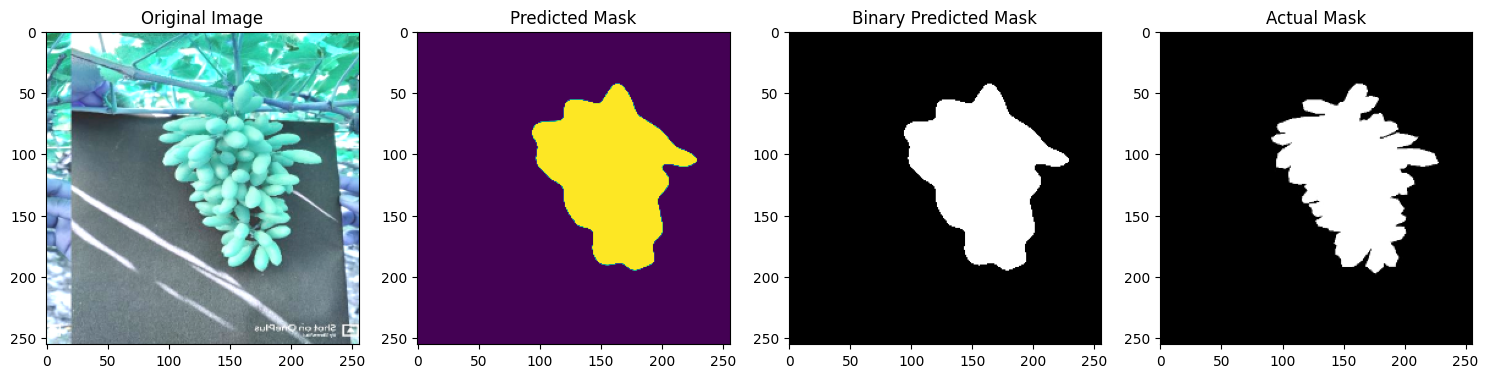

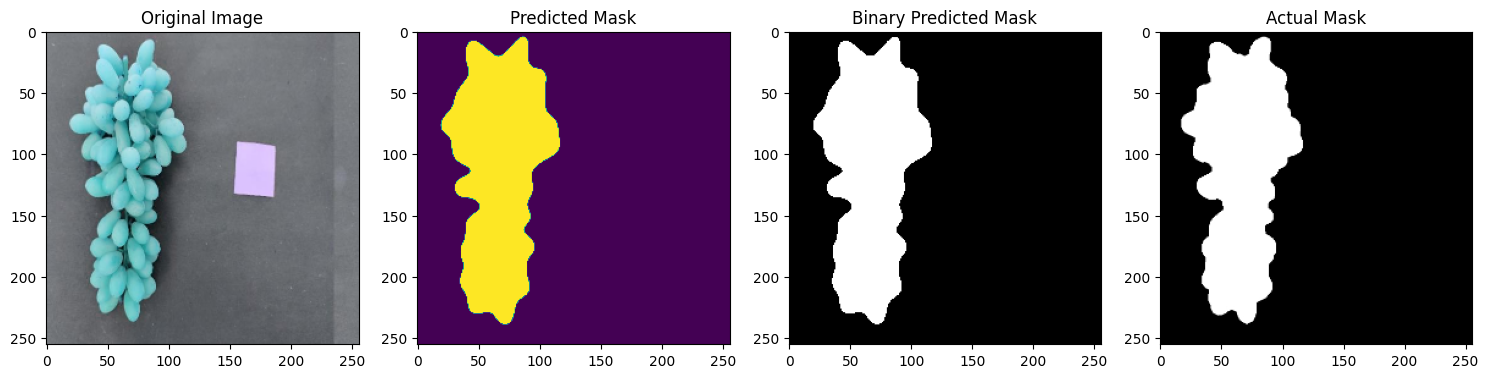

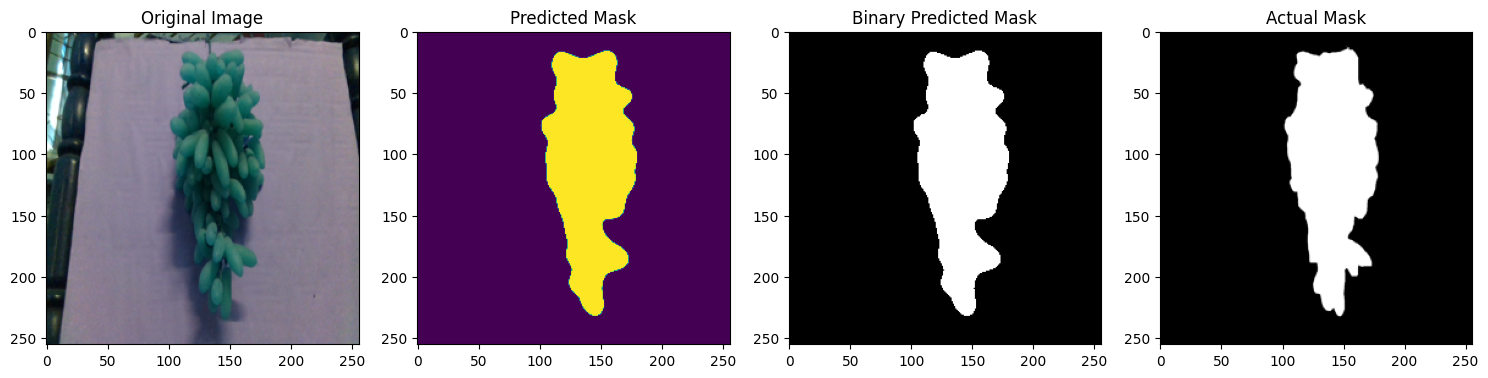

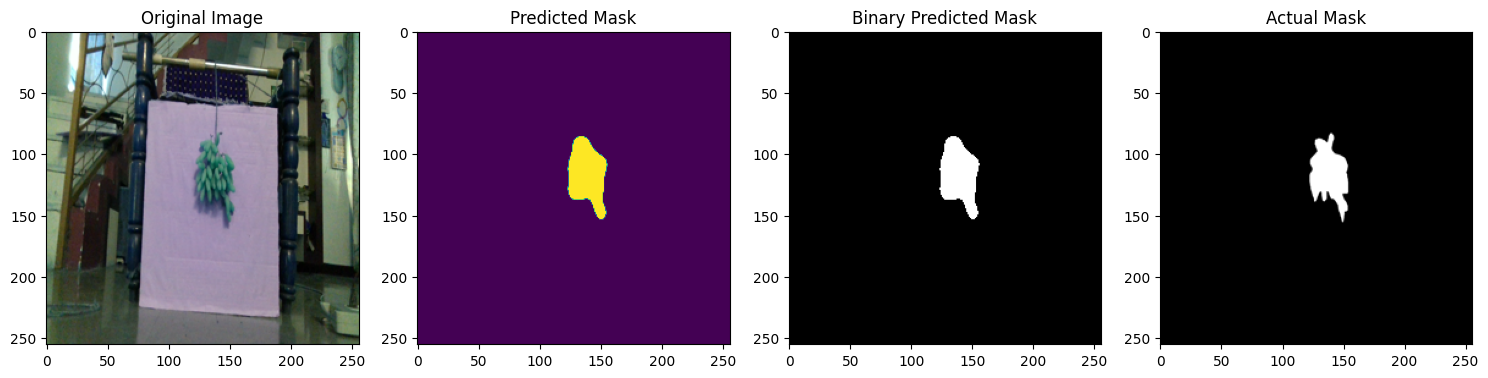

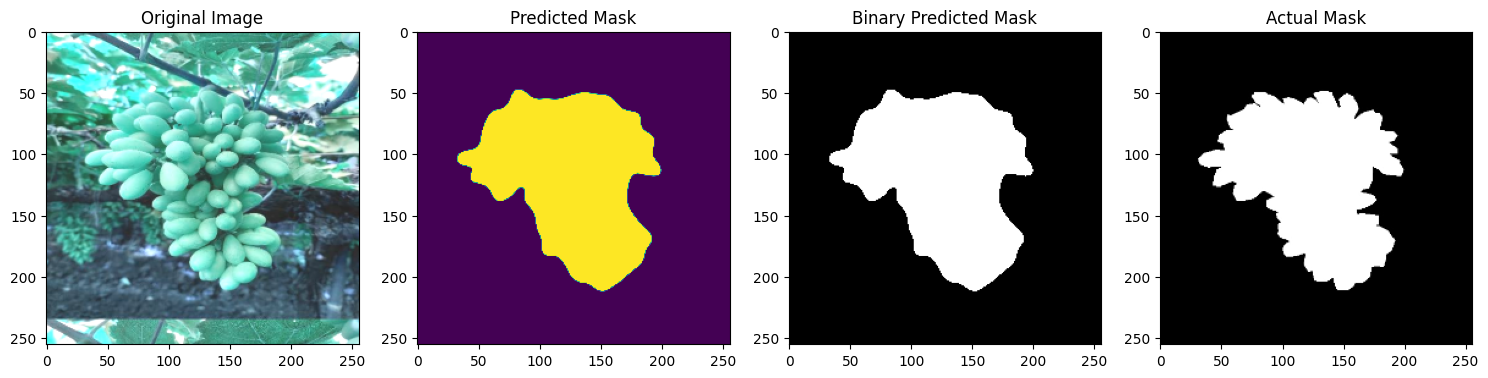

In [65]:
for i in range(20):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(images_test[i])
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(results[i])
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask[i], cmap='gray')
    plt.title('Binary Predicted Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(masks_test[i], cmap='gray')
    plt.title('Actual Mask')
    plt.tight_layout()
    plt.show()

In [67]:
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def compute_dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_coefficient = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_coefficient


iou = compute_iou(pred_mask, masks_test)
dice_coefficient = compute_dice_coefficient(pred_mask, masks_test)

print("IoU:", iou)
print("Dice Coefficient:", dice_coefficient)

IoU: 0.8961589880358585
Dice Coefficient: 0.9609660309972561


In [68]:
def compute_dice_loss(y_true, y_pred):
    dice_loss = 1 - compute_dice_coefficient(y_true, y_pred)
    return dice_loss

def compute_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = 1e-7
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    focal_loss = - (alpha * y_true * ((1 - y_pred) ** gamma) * np.log(y_pred) +
                    (1 - alpha) * (1 - y_true) * (y_pred ** gamma) * np.log(1 - y_pred))
    return focal_loss.mean()

dice_loss = compute_dice_loss(pred_mask, masks_test)
focal_loss = compute_focal_loss(pred_mask, masks_test)

print("Dice Loss:", dice_loss)
print("Focal Loss:", focal_loss)

Dice Loss: 0.03903396900274392
Focal Loss: 0.033828510656368216
